In [3]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import pandas as pd

#make 1000 samples
n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

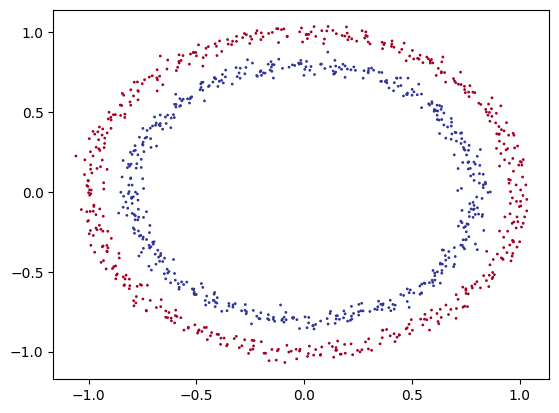

In [4]:
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            s=1,
            c=y, 
            cmap=plt.cm.RdYlBu);

In [5]:
circles = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


In [8]:
#turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [9]:
#split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [10]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [11]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        #create 2 nn.Linear layers capable of handling X and y input
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
    def forward(self, x):
        return self.layer_2(self.layer_1(x))

model = CircleModel().to(device)

In [12]:
untrained_preds = model(X_test)
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.5157],
        [-0.6756],
        [-0.1854],
        [-0.6089],
        [-0.3267],
        [-0.4233],
        [-0.7616],
        [-0.7029],
        [-0.1800],
        [-0.6879]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [13]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.1)

# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [14]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model(X_test.to(device))[:5]
y_logits

tensor([[-0.5157],
        [-0.6756],
        [-0.1854],
        [-0.6089],
        [-0.3267]], grad_fn=<SliceBackward0>)

In [15]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3739],
        [0.3372],
        [0.4538],
        [0.3523],
        [0.4190]], grad_fn=<SigmoidBackward0>)

In [16]:
y_preds = torch.round(y_pred_probs)


y_pred_labels = torch.round(torch.sigmoid(model(X_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

In [17]:
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model.train()
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits,
                    y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.72269, Accuracy: 50.00% | Test loss: 0.71349, Test acc: 50.00%
Epoch: 10 | Loss: 0.70579, Accuracy: 50.00% | Test loss: 0.69938, Test acc: 50.00%
Epoch: 20 | Loss: 0.69887, Accuracy: 45.88% | Test loss: 0.69423, Test acc: 48.50%
Epoch: 30 | Loss: 0.69593, Accuracy: 40.25% | Test loss: 0.69251, Test acc: 43.50%
Epoch: 40 | Loss: 0.69464, Accuracy: 45.88% | Test loss: 0.69211, Test acc: 49.00%
Epoch: 50 | Loss: 0.69403, Accuracy: 47.50% | Test loss: 0.69217, Test acc: 50.50%
Epoch: 60 | Loss: 0.69372, Accuracy: 47.88% | Test loss: 0.69239, Test acc: 50.50%
Epoch: 70 | Loss: 0.69354, Accuracy: 48.38% | Test loss: 0.69263, Test acc: 52.00%
Epoch: 80 | Loss: 0.69343, Accuracy: 49.00% | Test loss: 0.69286, Test acc: 48.50%
Epoch: 90 | Loss: 0.69336, Accuracy: 50.38% | Test loss: 0.69306, Test acc: 46.50%


In [18]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


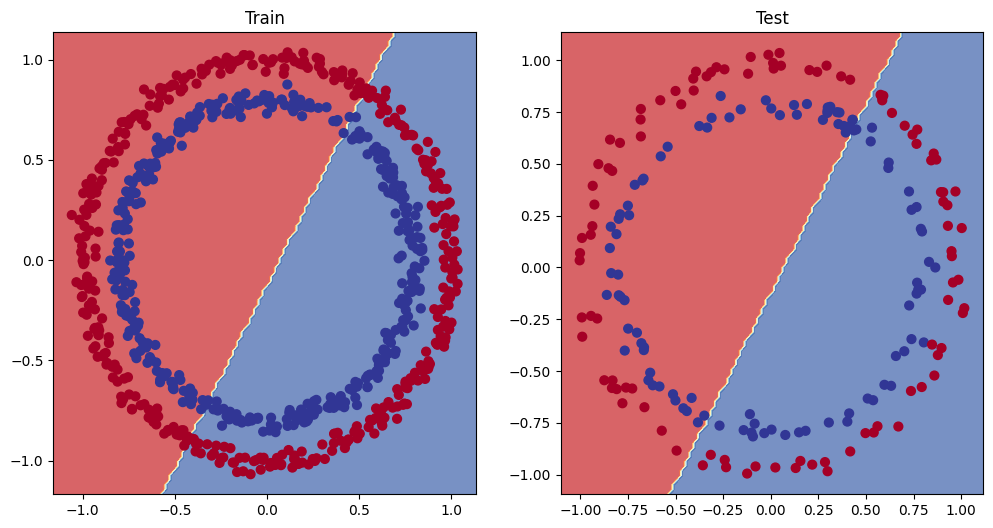

In [20]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)